# Supervised Algorithms For The Detection Of COVID-19 From Chest X-Ray Scan Images

### Import necessary libraries

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import VotingClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density
from imutils import paths
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import mahotas
from IPython.display import Image
from time import time
from pylab import imshow, gray, show
from os import path
import random
%matplotlib inline
print('Libraries successfully imported')

Libraries successfully imported


### Extract a 3D color histogram from the HSV colorspace to characterize the color distribution of the pixels in the images

In [2]:
def extract_color_histogram(image, bins=(8, 8, 8)):
#Extract using the supplied number of `bins` per channel,\
#then perform "in place" normalization in OpenCV, and return the flattened histogram as the feature vector
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
		[0, 256, 0, 256, 0, 256])
	cv2.normalize(hist, hist)
	return hist.flatten()

### Extract the Haralick Texture features using Mahotas, and return the feature vector

In [3]:
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the Haralick Texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

### Extract the Threshold Adjacency Statistics features using Mahotas, and return the feature vector

In [4]:
def fd_tas(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the Threshold Adjacency Statistics feature vector
    value = mahotas.features.tas(gray) 
    return value

### Specify the directory for the CT scan images, and initialize the matrices

In [5]:
# grab the list of images that we'll be describing
print("[INFO] Loading images...")
imagePaths = list(paths.list_images("train/"))
histogram = []
hara = []
tas = []
labels = []
features = []

[INFO] Loading images...


### Benchmark function

In [6]:
results = []
def benchmark(clf, name):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))
    
    print("classification report:")
    print(classification_report(y_test, pred))

    print("confusion matrix:")
    print(confusion_matrix(y_test, pred))

    print()
    clf_descr = name
    return clf_descr, score, train_time, test_time

### Loop over the input images:
#### 1) load the image and extract the class label (assuming that our path is in the format: /path/to/dataset/{class}.{image_num}.jpg
#### 2) extract the Color Histogram, the Haralick Texture, and Threshold Adjacency Statistics features
#### 3) update the matricies respectively

In [7]:
start_time = time()
for (i, imagePath) in enumerate(imagePaths):

	image = cv2.imread(imagePath)
	label = imagePath.split(os.path.sep)[-1].split(".")[0]

	haralick = fd_haralick(image)
	tass = fd_tas(image)
	hist = extract_color_histogram(image)
    

	histogram.append(hist)
	tas.append(tass)
	hara.append(haralick)
	labels.append(label)
    
	if i > 0 and i % 100 == 0:    # show an update every 100 images
		print("[INFO] Processed {}/{}".format(i, len(imagePaths)))
print("[INFO] Processed {}/{}".format(i+1, len(imagePaths)))
print("--- %s seconds ---" % (time() - start_time))

[INFO] Processed 100/1100
[INFO] Processed 200/1100
[INFO] Processed 300/1100
[INFO] Processed 400/1100
[INFO] Processed 500/1100
[INFO] Processed 600/1100
[INFO] Processed 700/1100
[INFO] Processed 800/1100
[INFO] Processed 900/1100
[INFO] Processed 1000/1100
[INFO] Processed 1100/1100
--- 327.27769446372986 seconds ---


### Show some information on the memory consumed each matrix

In [8]:
histogram = np.array(histogram)
labels = np.array(labels)
hara = np.array(hara)
tas = np.array(tas)
features = np.concatenate((hara, tas), axis=1)
features = np.concatenate((features, histogram), axis=1)


print("[INFO] histogram matrix: {} {:.2f}MB".format(
	histogram.shape, histogram.nbytes / (1024 * 1000.0)))
print("[INFO] haralick matrix: {} {:.2f}MB".format(
    hara.shape, hara.nbytes / (1024 * 1000.0)))
print("[INFO] TAS matrix: {} {:.2f}MB".format(
    tas.shape, tas.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {} {:.2f}MB".format(
    features.shape, features.nbytes / (1024 * 1000.0)))

[INFO] histogram matrix: (1100, 512) 2.20MB
[INFO] haralick matrix: (1100, 13) 0.11MB
[INFO] TAS matrix: (1100, 54) 0.46MB
[INFO] features matrix: (1100, 579) 4.98MB


### Split partition the data into training and testing splits, using 80% of the data for training and 20% for testing, with a random state of 10

In [9]:
(trainHara, testHara, trainHaraL, testHaraL) = train_test_split(hara, labels, test_size=0.20, random_state=10)
(trainTas, testTas, trainTasL, testTasL) = train_test_split(tas, labels, test_size=0.20, random_state=10)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(histogram, labels, test_size=0.20, random_state=10)

(trainF, testF, trainFL, testFL) = train_test_split(features, labels, test_size=0.20, random_state=10)

In [10]:
y_train_b = trainFL.tolist()
y_test_b = testFL.tolist()

/home/amr/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Training Data')

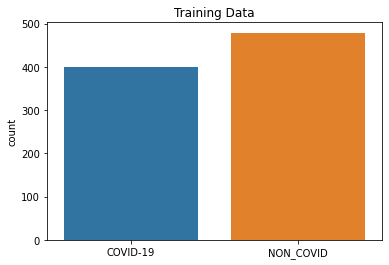

In [11]:
import seaborn as sns
sns.countplot(y_train_b, order = ['COVID-19', 'NON_COVID'])
plt.title('Training Data')

/home/amr/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Testing Data')

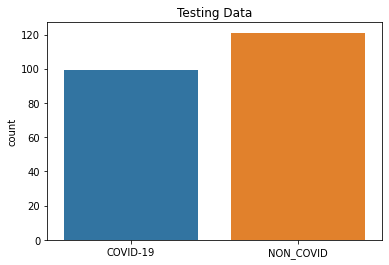

In [12]:
sns.countplot(y_test_b, order = ['COVID-19', 'NON_COVID'])
plt.title('Testing Data')

### Note:
### You can skip to the "Anvil App" section to use the app

## A. Training the algorithms using the Color Histogram features

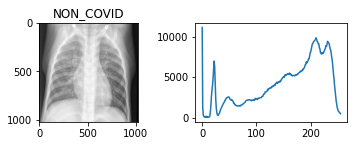

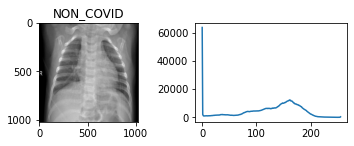

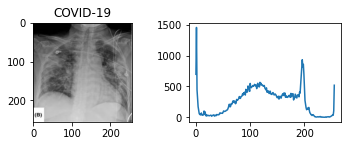

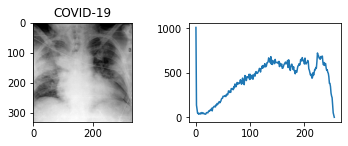

In [13]:
imagePaths = list(paths.list_images("train/"))
rand = random.choices(imagePaths, k=4)
for (i, rand) in enumerate(rand):
    img = cv2.imread(rand)
    hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
    label = rand.split(os.path.sep)[-1].split(".")[0]
    plt.subplot(221), plt.title(label), plt.imshow(img, 'gray')
    plt.subplot(222), plt.plot(hist_full)
    plt.show()

### Specify the inputs

In [14]:
X = histogram
y = labels
X_train = trainFeat
X_test = testFeat
y_train = trainLabels
y_test = testLabels

### Perform standardization by centering and scaling the training set and the test set

In [15]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

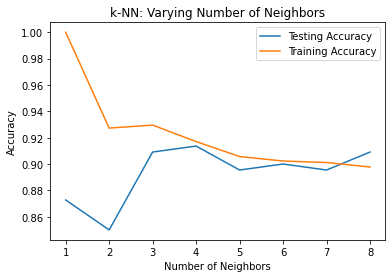

In [16]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the color histogram representations

In [17]:
print("[INFO] evaluating k-NN on color histogram accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
results.append(benchmark(knn, 'k-NN on Color Histograms'))

[INFO] evaluating k-NN on color histogram accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.031s
test time:  0.110s
accuracy:   0.909
classification report:
              precision    recall  f1-score   support

    COVID-19       0.91      0.89      0.90        99
   NON_COVID       0.91      0.93      0.92       121

    accuracy                           0.91       220
   macro avg       0.91      0.91      0.91       220
weighted avg       0.91      0.91      0.91       220

confusion matrix:
[[ 88  11]
 [  9 112]]



### Train and evaluate a Linear SVM classifer on the color histogram representations

In [18]:
print("[INFO] evaluating Linear SVM color histogram accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on Color Histograms'))

[INFO] evaluating Linear SVM color histogram accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 0.297s
test time:  0.048s
accuracy:   0.855
dimensionality: 512
density: 0.015625
classification report:
              precision    recall  f1-score   support

    COVID-19       0.87      0.80      0.83        99
   NON_COVID       0.84      0.90      0.87       121

    accuracy                           0.85       220
   macro avg       0.86      0.85      0.85       220
weighted avg       0.86      0.85      0.85       220

confusion matrix:
[[ 79  20]
 [ 12 109]]



### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the color histogram representations and print the classification report for the model

In [19]:
svc = svm.SVC()

# Specify the hyperparameter space
parameters = {'C':[0.1, 1, 10, 100],
              'gamma':[0.1, 1, 10, 100]}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(svc, parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'C': 10, 'gamma': 0.1}


In [20]:
print("[INFO] evaluating RBF SVM on color histogram with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C=10, gamma=0.1)
results.append(benchmark(rbf_svc, 'RBF SVM on Color Histograms'))

[INFO] evaluating RBF SVM on color histogram with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=10, gamma=0.1)
train time: 0.220s
test time:  0.046s
accuracy:   0.927
classification report:
              precision    recall  f1-score   support

    COVID-19       0.93      0.91      0.92        99
   NON_COVID       0.93      0.94      0.93       121

    accuracy                           0.93       220
   macro avg       0.93      0.93      0.93       220
weighted avg       0.93      0.93      0.93       220

confusion matrix:
[[ 90   9]
 [  7 114]]



### Train and evaluate a Decision Tree Classifier

In [21]:
print("[INFO] evaluating Decision Tree on color histogram accuracy...")
dt = DecisionTreeClassifier()
results.append(benchmark(dt, 'Decision Tree on Color Histograms'))

[INFO] evaluating Decision Tree on color histogram accuracy...
________________________________________________________________________________
Training: 
DecisionTreeClassifier()
train time: 0.037s
test time:  0.000s
accuracy:   0.864
classification report:
              precision    recall  f1-score   support

    COVID-19       0.86      0.83      0.85        99
   NON_COVID       0.86      0.89      0.88       121

    accuracy                           0.86       220
   macro avg       0.86      0.86      0.86       220
weighted avg       0.86      0.86      0.86       220

confusion matrix:
[[ 82  17]
 [ 13 108]]



### Train and evaluate a Voting Classifier with hard voting on the Color Histogram features

In [22]:
print("[INFO] evaluating Voting Classifier on color histogram accuracy...")
estimator = []
estimator.append(('1', knn))
estimator.append(('2', rbf_svc))
estimator.append(('3', dt))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on Color Histograms'))

[INFO] evaluating Voting Classifier on color histogram accuracy...
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', KNeighborsClassifier(n_neighbors=3)),
                             ('2', SVC(C=10, gamma=0.1)),
                             ('3', DecisionTreeClassifier())])
train time: 0.262s
test time:  0.131s
accuracy:   0.918
classification report:
              precision    recall  f1-score   support

    COVID-19       0.92      0.90      0.91        99
   NON_COVID       0.92      0.93      0.93       121

    accuracy                           0.92       220
   macro avg       0.92      0.92      0.92       220
weighted avg       0.92      0.92      0.92       220

confusion matrix:
[[ 89  10]
 [  8 113]]



## B. Training the algorithms using the Haralick Texture features

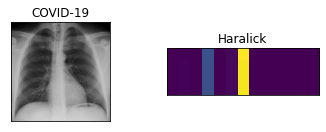

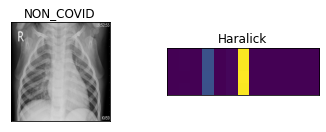

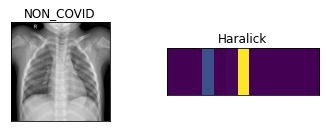

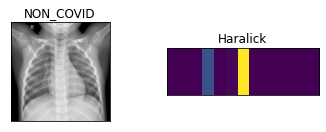

In [23]:
imagePaths = list(paths.list_images("train/"))
rand = random.choices(imagePaths, k=4)
for (i, rand) in enumerate(rand):
    img = cv2.imread(rand)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray)
    plt.subplot(2,2,1),plt.imshow(img, cmap = 'gray')
    label = rand.split(os.path.sep)[-1].split(".")[0]
    plt.title(label), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,2),plt.imshow(haralick)
    plt.title('Haralick'), plt.xticks([]), plt.yticks([])
    plt.show()

### Specify the inputs

In [24]:
X = hara
y = labels
X_train = trainHara
X_test = testHara
y_train = trainHaraL
y_test = testHaraL

### Perform standardization by centering and scaling the training set and the test set

In [25]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

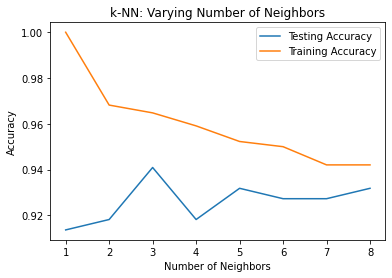

In [26]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the Haralick Texture features

In [27]:
print("[INFO] evaluating k-NN on Haralick Texture accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
results.append(benchmark(knn, 'k-NN on Haralick Texture'))

[INFO] evaluating k-NN on Haralick Texture accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.002s
test time:  0.011s
accuracy:   0.941
classification report:
              precision    recall  f1-score   support

    COVID-19       0.96      0.91      0.93        99
   NON_COVID       0.93      0.97      0.95       121

    accuracy                           0.94       220
   macro avg       0.94      0.94      0.94       220
weighted avg       0.94      0.94      0.94       220

confusion matrix:
[[ 90   9]
 [  4 117]]



### Train and evaluate a Linear SVM classifer on the Haralick Texture features

In [28]:
print("[INFO] evaluating Linear SVM on Haralick Texture accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on Haralick Texture'))

[INFO] evaluating Linear SVM on Haralick Texture accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 0.012s
test time:  0.001s
accuracy:   0.964
dimensionality: 13
density: 1.000000
classification report:
              precision    recall  f1-score   support

    COVID-19       0.95      0.97      0.96        99
   NON_COVID       0.97      0.96      0.97       121

    accuracy                           0.96       220
   macro avg       0.96      0.96      0.96       220
weighted avg       0.96      0.96      0.96       220

confusion matrix:
[[ 96   3]
 [  5 116]]



### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the Haralick Texture features and print the classification report for the model

In [29]:
svc = svm.SVC()

# Specify the hyperparameter space
parameters = {'C':[0.1, 1, 10, 100],
              'gamma':[0.1, 1, 10, 100]}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(svc, parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'C': 100, 'gamma': 0.1}


In [30]:
print("[INFO] evaluating RBF SVM on Haralick Texture with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C=100, gamma=0.1)
results.append(benchmark(rbf_svc, 'RBF SVM on Raw Pixels'))

[INFO] evaluating RBF SVM on Haralick Texture with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=100, gamma=0.1)
train time: 0.018s
test time:  0.001s
accuracy:   0.973
classification report:
              precision    recall  f1-score   support

    COVID-19       0.98      0.96      0.97        99
   NON_COVID       0.97      0.98      0.98       121

    accuracy                           0.97       220
   macro avg       0.97      0.97      0.97       220
weighted avg       0.97      0.97      0.97       220

confusion matrix:
[[ 95   4]
 [  2 119]]



### Train and evaluate a Decision Tree Classifier on the Haralick Texture representations

In [31]:
print("[INFO] evaluating Decision Tree on Haralick Texture accuracy...")
#Train Decision Tree Classifer using default parameters
dt = DecisionTreeClassifier()
results.append(benchmark(dt, 'Decision Tree on Haralick Texture'))

[INFO] evaluating Decision Tree on Haralick Texture accuracy...
________________________________________________________________________________
Training: 
DecisionTreeClassifier()
train time: 0.017s
test time:  0.000s
accuracy:   0.882
classification report:
              precision    recall  f1-score   support

    COVID-19       0.85      0.89      0.87        99
   NON_COVID       0.91      0.88      0.89       121

    accuracy                           0.88       220
   macro avg       0.88      0.88      0.88       220
weighted avg       0.88      0.88      0.88       220

confusion matrix:
[[ 88  11]
 [ 15 106]]



### Train and evaluate a Voting Classifier with hard voting on the Haralick Texture representations

In [32]:
print("[INFO] evaluating Voting Classifier on Haralick Texture...")
start_time = time()
estimator = []
estimator.append(('1', knn))
estimator.append(('2', rbf_svc))
estimator.append(('3', linear_svc))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on Haralick Texture'))

[INFO] evaluating Voting Classifier on Haralick Texture...
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', KNeighborsClassifier(n_neighbors=3)),
                             ('2', SVC(C=100, gamma=0.1)),
                             ('3', SVC(kernel='linear'))])
train time: 0.031s
test time:  0.013s
accuracy:   0.977
classification report:
              precision    recall  f1-score   support

    COVID-19       0.98      0.97      0.97        99
   NON_COVID       0.98      0.98      0.98       121

    accuracy                           0.98       220
   macro avg       0.98      0.98      0.98       220
weighted avg       0.98      0.98      0.98       220

confusion matrix:
[[ 96   3]
 [  2 119]]



## C. Training the algorithms using Threshold Adjacency Statistics

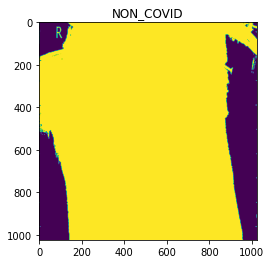

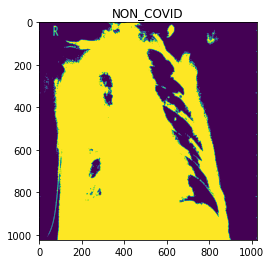

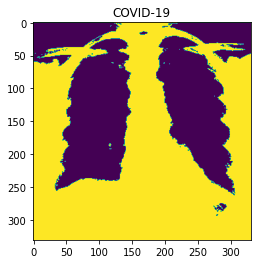

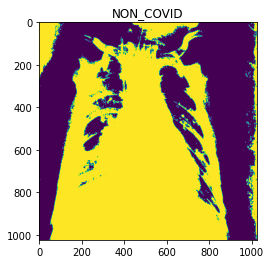

In [33]:
from pylab import imshow, gray, show
from os import path
import random
imagePaths = list(paths.list_images("train/"))
rand = random.choices(imagePaths, k=4)
for (i, rand) in enumerate(rand):
    img = cv2.imread(rand)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.uint8)
    T_rc = mahotas.rc(gray)
    label = rand.split(os.path.sep)[-1].split(".")[0]
    plt.title(label)
    imshow(gray > T_rc)
    show()

### Specify the inputs

In [34]:
X = tas
y = labels
X_train = trainTas
X_test = testTas
y_train = trainTasL
y_test = testTasL

### Perform standardization by centering and scaling the training set and the test set

In [35]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

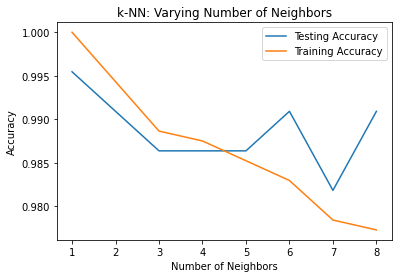

In [36]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the Threshold Adjacency Statistics (TAS)

In [37]:
start_time = time()
print("[INFO] evaluating k-NN on TAS accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
results.append(benchmark(knn, 'k-NN on TAS'))

[INFO] evaluating k-NN on TAS accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.004s
test time:  0.022s
accuracy:   0.986
classification report:
              precision    recall  f1-score   support

    COVID-19       0.99      0.98      0.98        99
   NON_COVID       0.98      0.99      0.99       121

    accuracy                           0.99       220
   macro avg       0.99      0.99      0.99       220
weighted avg       0.99      0.99      0.99       220

confusion matrix:
[[ 97   2]
 [  1 120]]



### Train and evaluate a Linear SVM classifer on the TAS representations

In [38]:
print("[INFO] evaluating Linear SVM on TAS accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on TAS'))

[INFO] evaluating Linear SVM on TAS accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 0.014s
test time:  0.001s
accuracy:   0.986
dimensionality: 54
density: 1.000000
classification report:
              precision    recall  f1-score   support

    COVID-19       0.98      0.99      0.98        99
   NON_COVID       0.99      0.98      0.99       121

    accuracy                           0.99       220
   macro avg       0.99      0.99      0.99       220
weighted avg       0.99      0.99      0.99       220

confusion matrix:
[[ 98   1]
 [  2 119]]



### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the TAS representations and print the classification report for the model

In [39]:
svc = svm.SVC()

# Specify the hyperparameter space
parameters = {'C':[0.1, 1, 10, 100],
              'gamma':[0.1, 1, 10, 100, 'scale']}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(svc, parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'C': 10, 'gamma': 'scale'}


In [40]:
print("[INFO] evaluating RBF SVM on TAS with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C=10, gamma='scale')
results.append(benchmark(rbf_svc, 'RBF SVM on TAS'))

[INFO] evaluating RBF SVM on TAS with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=10)
train time: 0.022s
test time:  0.003s
accuracy:   0.991
classification report:
              precision    recall  f1-score   support

    COVID-19       0.98      1.00      0.99        99
   NON_COVID       1.00      0.98      0.99       121

    accuracy                           0.99       220
   macro avg       0.99      0.99      0.99       220
weighted avg       0.99      0.99      0.99       220

confusion matrix:
[[ 99   0]
 [  2 119]]



### Train and evaluate a Decision Tree Classifier on the TAS representations

In [41]:
print("[INFO] evaluating Decision Tree on TAS...")
#Train Decision Tree Classifer using default parameters
dt = DecisionTreeClassifier()
results.append(benchmark(dt, 'Decision Tree on TAS'))

[INFO] evaluating Decision Tree on TAS...
________________________________________________________________________________
Training: 
DecisionTreeClassifier()
train time: 0.025s
test time:  0.000s
accuracy:   0.973
classification report:
              precision    recall  f1-score   support

    COVID-19       0.96      0.98      0.97        99
   NON_COVID       0.98      0.97      0.97       121

    accuracy                           0.97       220
   macro avg       0.97      0.97      0.97       220
weighted avg       0.97      0.97      0.97       220

confusion matrix:
[[ 97   2]
 [  4 117]]



### Train and evaluate a Voting Classifier with hard voting on the TAS representations

In [42]:
print("[INFO] evaluating Voting Classifier on TAS...")
start_time = time()
estimator = []
estimator.append(('1', knn))
estimator.append(('2', rbf_svc))
estimator.append(('3', linear_svc))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on TAS'))

[INFO] evaluating Voting Classifier on TAS...
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', KNeighborsClassifier(n_neighbors=3)),
                             ('2', SVC(C=10)), ('3', SVC(kernel='linear'))])
train time: 0.033s
test time:  0.027s
accuracy:   0.995
classification report:
              precision    recall  f1-score   support

    COVID-19       0.99      1.00      0.99        99
   NON_COVID       1.00      0.99      1.00       121

    accuracy                           1.00       220
   macro avg       0.99      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220

confusion matrix:
[[ 99   0]
 [  1 120]]



## D. Training the algorithms using all features (Histograms, Haralink, & TAS)

### Specify the inputs

In [43]:
X = features
y = labels
X_train = trainF
X_test = testF
y_train = trainFL
y_test = testFL
results_feat = []

### Perform standardization by centering and scaling the training set and the test set

In [44]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

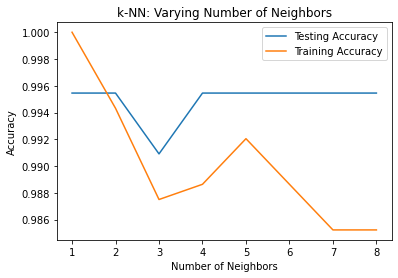

In [45]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the Features matrix

In [46]:
print("[INFO] evaluating k-NN on Features accuracy...")
knn = KNeighborsClassifier(n_neighbors=2)
results.append(benchmark(knn, 'k-NN on Features'))

[INFO] evaluating k-NN on Features accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=2)
train time: 0.035s
test time:  0.172s
accuracy:   0.995
classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.99      0.99        99
   NON_COVID       0.99      1.00      1.00       121

    accuracy                           1.00       220
   macro avg       1.00      0.99      1.00       220
weighted avg       1.00      1.00      1.00       220

confusion matrix:
[[ 98   1]
 [  0 121]]



### Train and evaluate a Linear SVM classifer on the Features matrix

In [47]:
print("[INFO] evaluating Linear SVM on Features accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on Features'))

[INFO] evaluating Linear SVM on Features accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 0.072s
test time:  0.008s
accuracy:   0.995
dimensionality: 579
density: 0.129534
classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.99      0.99        99
   NON_COVID       0.99      1.00      1.00       121

    accuracy                           1.00       220
   macro avg       1.00      0.99      1.00       220
weighted avg       1.00      1.00      1.00       220

confusion matrix:
[[ 98   1]
 [  0 121]]



### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the Features matrix and print the classification report for the model

In [48]:
svc = svm.SVC()

# Specify the hyperparameter space
parameters = {'C':[0.1, 1, 10, 100],
              'gamma':[0.1, 1, 10, 'scale']}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(svc, parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'C': 1, 'gamma': 'scale'}


In [49]:
print("[INFO] evaluating RBF SVM on Features with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C=1, gamma='scale')
results.append(benchmark(rbf_svc, 'RBF SVM on Features'))

[INFO] evaluating RBF SVM on Features with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=1)
train time: 0.148s
test time:  0.026s
accuracy:   0.986
classification report:
              precision    recall  f1-score   support

    COVID-19       0.98      0.99      0.98        99
   NON_COVID       0.99      0.98      0.99       121

    accuracy                           0.99       220
   macro avg       0.99      0.99      0.99       220
weighted avg       0.99      0.99      0.99       220

confusion matrix:
[[ 98   1]
 [  2 119]]



Text(0.5, 1.0, '2-class Precision-Recall curve')

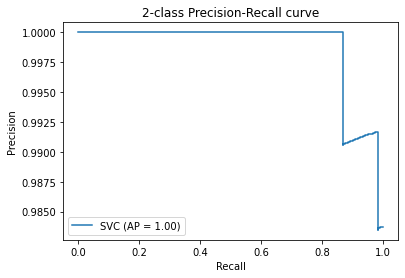

In [50]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
disp = plot_precision_recall_curve(rbf_svc, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve')

### Train and evaluate a Decision Tree Classifier on the Features matrix

In [51]:
print("[INFO] evaluating Decision Tree on Features...")
dt = DecisionTreeClassifier()
results.append(benchmark(dt, 'Decision Tree on Features'))

[INFO] evaluating Decision Tree on Features...
________________________________________________________________________________
Training: 
DecisionTreeClassifier()
train time: 0.033s
test time:  0.001s
accuracy:   0.986
classification report:
              precision    recall  f1-score   support

    COVID-19       0.99      0.98      0.98        99
   NON_COVID       0.98      0.99      0.99       121

    accuracy                           0.99       220
   macro avg       0.99      0.99      0.99       220
weighted avg       0.99      0.99      0.99       220

confusion matrix:
[[ 97   2]
 [  1 120]]



### Train and evaluate a Voting Classifier with hard voting on the Features matrix

In [52]:
estimator = []
estimator.append(('1', rbf_svc))
estimator.append(('2', linear_svc))
estimator.append(('3', knn))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on Features'))

________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', SVC(C=1)), ('2', SVC(kernel='linear')),
                             ('3', KNeighborsClassifier(n_neighbors=2))])
train time: 0.209s
test time:  0.179s
accuracy:   0.995
classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.99      0.99        99
   NON_COVID       0.99      1.00      1.00       121

    accuracy                           1.00       220
   macro avg       1.00      0.99      1.00       220
weighted avg       1.00      1.00      1.00       220

confusion matrix:
[[ 98   1]
 [  0 121]]



## Benchmark

In [53]:
def scoreof(results):
    indices = np.arange(len(results))
    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results

    x = clf_names
    y = score
    x_pos = [i for i, _ in enumerate(x)]

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x_pos, y, color='b')
    plt.ylabel("Score")
    plt.title("Score")
    plt.xticks(x_pos, x)
    # Turn on the grid
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%f' % float(height),
            ha='center', va='bottom')
    autolabel(rects1)
    plt.show()

In [54]:
def timeof(results, ind):
    indices = np.arange(len(results))
    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results

    training_time = np.array(training_time)
    test_time = np.array(test_time)

    plt.figure(figsize=(15, 15))
    plt.title("Execution Time")
    plt.barh(indices + .3, training_time, .3, label="training time", color='c')
    plt.barh(indices + .6, test_time, .3, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')

    for i, c in zip(indices, clf_names):
        plt.text(ind, i, c)

    plt.show()


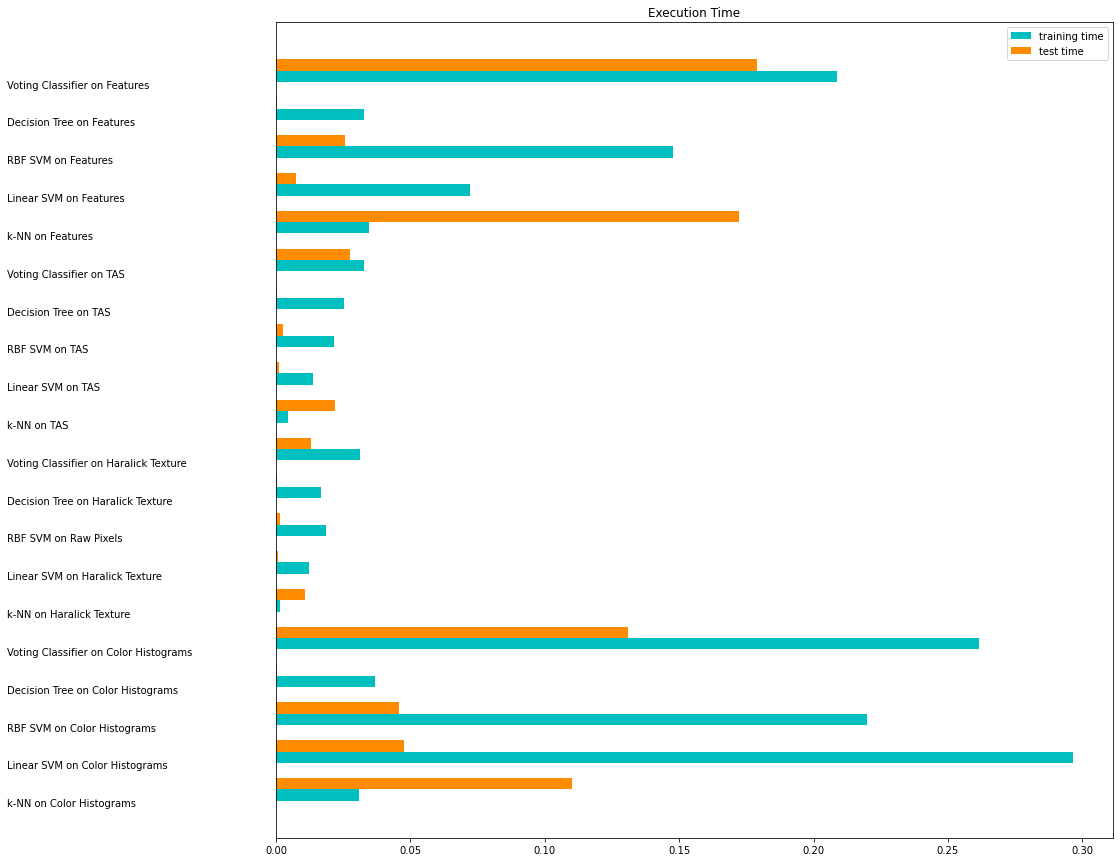

In [56]:
timeof(results, -0.10)

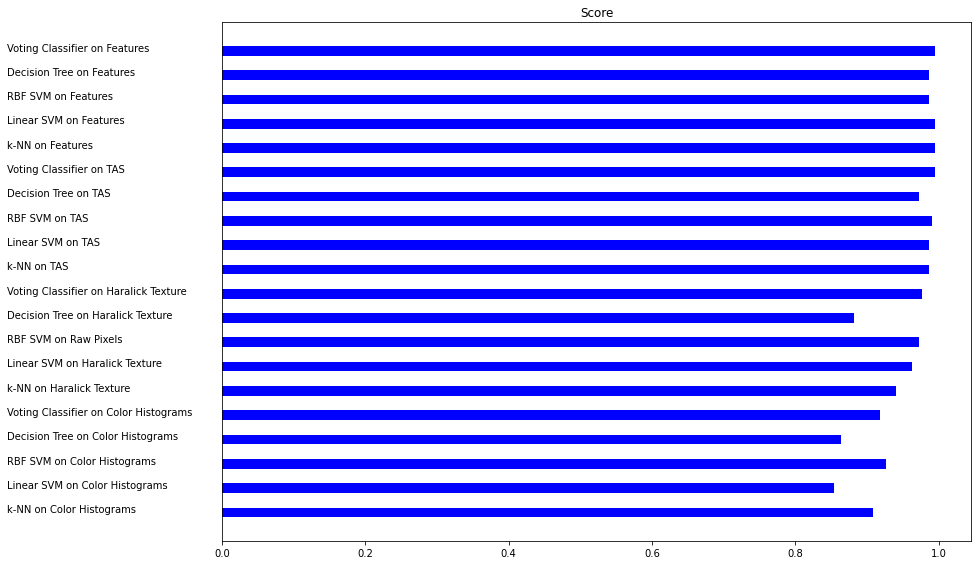

In [57]:
indices = np.arange(len(results))

clf_names, score, training_time, test_time = [[x[i] for x in results] for i in range(4)]

plt.figure(figsize=(16, 8))
plt.title("Score")
plt.barh(indices, score, .4, label="score", color='blue')
plt.yticks(())
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

### Benchmark Features

In [58]:
results_feat = []
for clf, name in (
        (knn, "k-NN"),
        (linear_svc, "Linear SVM"),
        (rbf_svc, "RBF SVM"),
        (dt, "Decision Tree"),
        (vot_hard, "Voting Classifier")):
    print('=' * 80)
    print(name)
    results_feat.append(benchmark(clf, name))


print('=' * 80)
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.

k-NN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=2)
train time: 0.039s
test time:  0.173s
accuracy:   0.995
classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.99      0.99        99
   NON_COVID       0.99      1.00      1.00       121

    accuracy                           1.00       220
   macro avg       1.00      0.99      1.00       220
weighted avg       1.00      1.00      1.00       220

confusion matrix:
[[ 98   1]
 [  0 121]]

Linear SVM
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 0.059s
test time:  0.006s
accuracy:   0.995
dimensionality: 579
density: 0.129534
classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.99      0.99        99
   NON_COVID       0.99      1.00      1.00       121

    accuracy  

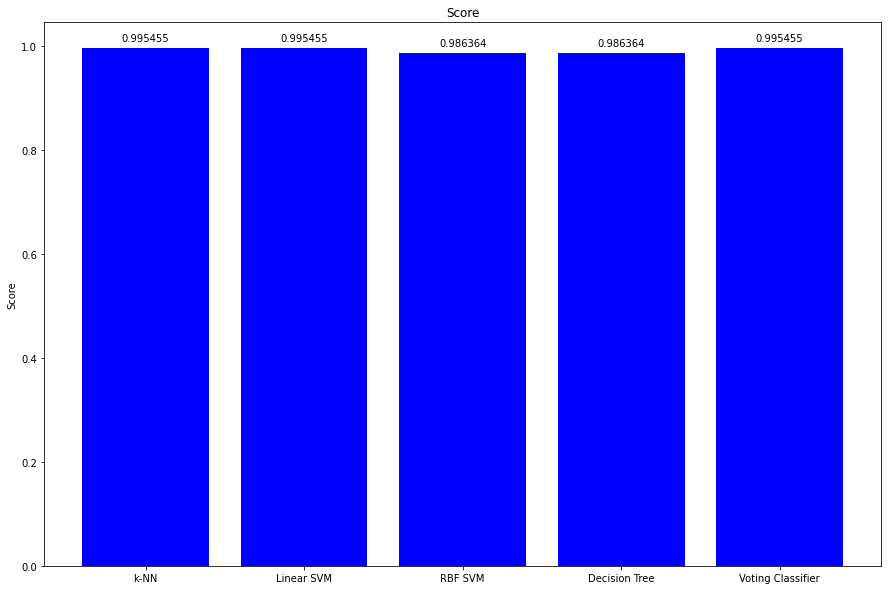

In [59]:
scoreof(results_feat)

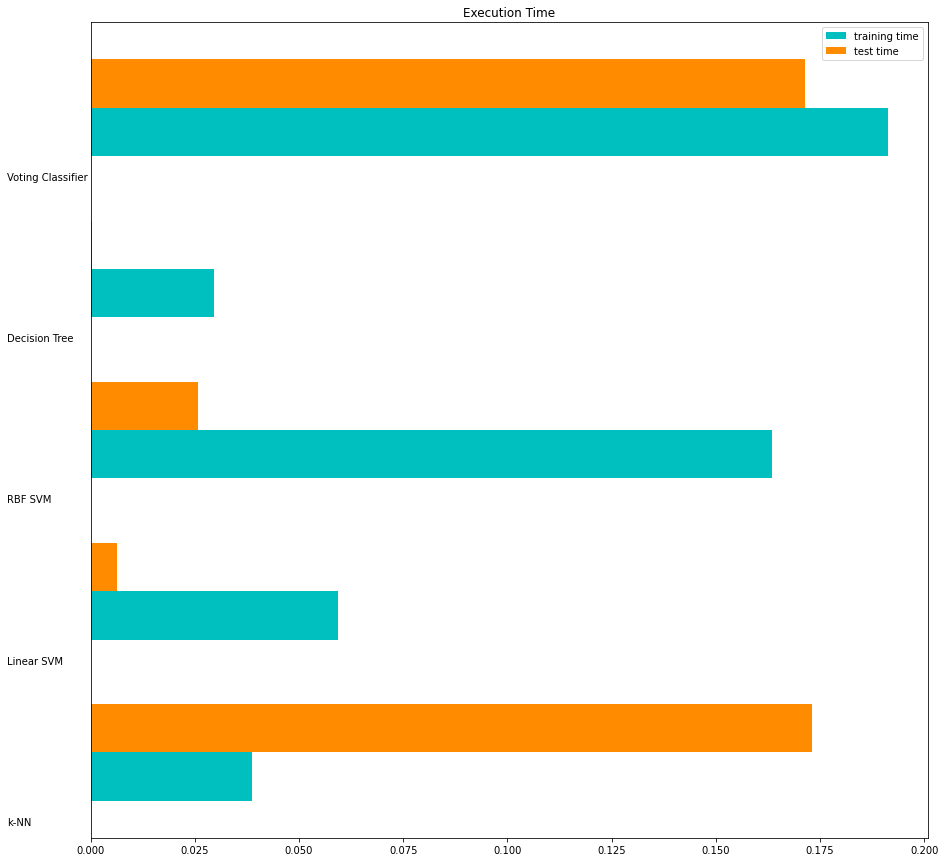

In [60]:
timeof(results_feat, -0.02)

## Further method: Neural Networks

### Train and evaluate a Multi-layer Perceptron classifier on the Features matrix

In [61]:
from sklearn.neural_network import MLPClassifier
print("[INFO] evaluating MLPClassifier on Features...")
start_time = time()
mlp = MLPClassifier(hidden_layer_sizes=500)
results_feat.append(benchmark(mlp, 'MLPClassifier'))

[INFO] evaluating MLPClassifier on Features...
________________________________________________________________________________
Training: 
MLPClassifier(hidden_layer_sizes=500)
train time: 7.646s
test time:  0.004s
accuracy:   0.995
classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.99      0.99        99
   NON_COVID       0.99      1.00      1.00       121

    accuracy                           1.00       220
   macro avg       1.00      0.99      1.00       220
weighted avg       1.00      1.00      1.00       220

confusion matrix:
[[ 98   1]
 [  0 121]]



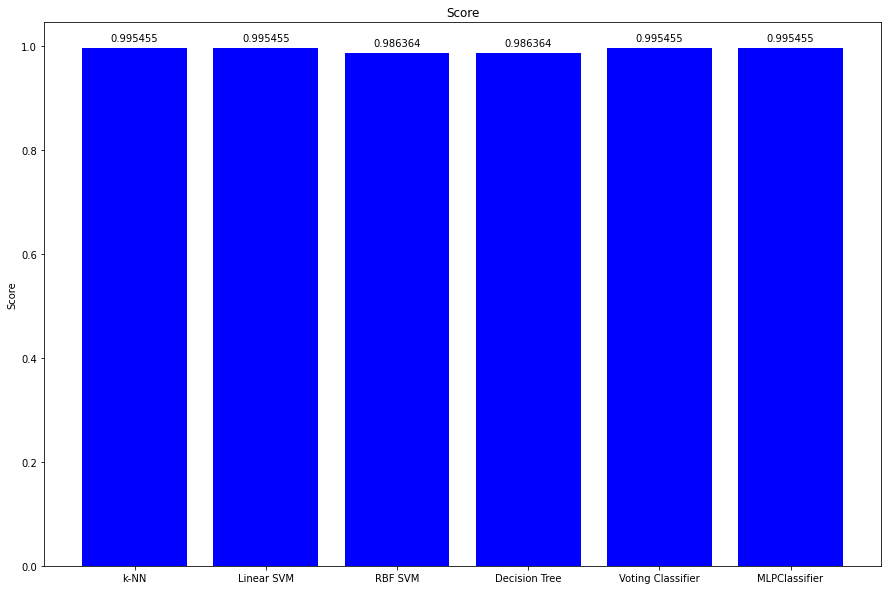

In [62]:
scoreof(results_feat)

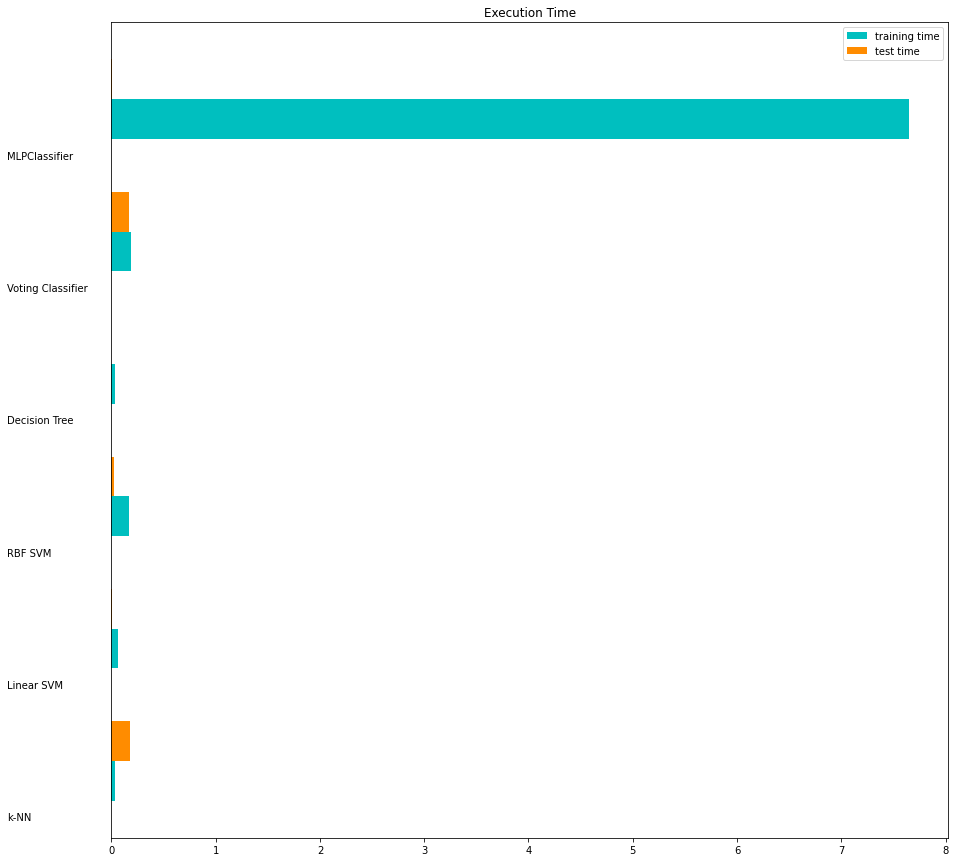

In [63]:
timeof(results_feat, -1)

## Anvil App

In [117]:
X = features
y = labels
X_train = trainF
X_test = testF
y_train = trainFL
y_test = testFL
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)
linear_svc = svm.SVC(kernel='linear', probability=True)
linear_svc.fit(X_train, y_train)
rbf_svc = svm.SVC(kernel='rbf', C = 10, gamma = 0.1, probability=True)
rbf_svc.fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
estimator = []
estimator.append(('1', knn))
estimator.append(('2', linear_svc))
estimator.append(('3', rbf_svc))
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('1', KNeighborsClassifier(n_neighbors=3)),
                             ('2', SVC(kernel='linear', probability=True)),
                             ('3', SVC(C=10, gamma=0.1, probability=True))])

In [119]:
import anvil.server
anvil.server.connect("3YPAFQMZCK7HF3I4K2LTMRLD-XLRLG4JQYH74F4SS")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


In [ ]:
import anvil.media

@anvil.server.callable
def classify_image(file):
    with anvil.media.TempFile(file) as filename:
        img = cv2.imread(filename)
    hist_imp = []
    hara_imp = []
    tas_imp = []
    features_imp = []
    
    hist_imp.append(extract_color_histogram(img))
    tas_imp.append(fd_tas(img))
    hara_imp.append(fd_haralick(img))
    hist_imp = np.array(hist_imp)
    hara_imp = np.array(hara_imp)
    tas_imp = np.array(tas_imp)
    features_imp = np.concatenate((hara_imp, tas_imp), axis=1)
    features_imp = np.concatenate((features_imp, hist_imp), axis=1)

    X_pred = features_imp
    X_pred = sc.transform(X_pred)

    return('k-NN Propability of COVID-19 is {:.2f}%'.format(knn.predict_proba(X_pred)[0][0]*100) +
            '\nSVM Propability of COVID-19 is {:.2f}%'.format(rbf_svc.predict_proba(X_pred)[0][0]*100) +
            '\nLinearSVC Propability of COVID-19 is {:.2f}%'.format(linear_svc.predict_proba(X_pred)[0][0]*100) +
            '\nMLP Propability of COVID-19 is {:.2f}%'.format(mlp.predict_proba(X_pred)[0][0]*100) +
            '\nDecision Tree Result is {}'.format(dt.predict(X_pred)[0]) +
            '\nVoting Classifier Hard Voting Result is {}'.format(vot_hard.predict(X_pred)[0]))

anvil.server.wait_forever()

### Now go to https://XLRLG4JQYH74F4SS.anvil.app/VMNA2YYY6MBAPGAFDPMDIOIW and upload an X-ray image. For optimum results used a cropped image that looks like this

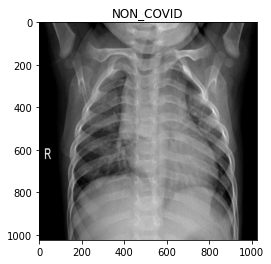

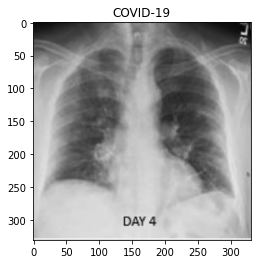

In [15]:
imagePaths = list(paths.list_images("train/"))
rand = random.choices(imagePaths, k=2)
for (i, rand) in enumerate(rand):
    img = cv2.imread(rand)
    label = rand.split(os.path.sep)[-1].split(".")[0]
    plt.plot(221), plt.title(label), plt.imshow(img, 'gray')
    plt.show()

In [122]:
anvil.server.disconnect()

Anvil websocket closed (code 1000, reason=b'')
